In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import japanize_matplotlib

#出力する行数を設定、省略をなくす
pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_absolute_error

#データをまとめて読み込み、訓練データはtrain
train_files = glob.glob('./data/train/*.csv')
train = pd.DataFrame()
for file in train_files:
    train1 = pd.read_csv(file)
    cat_train = pd.concat([train,train1])
    train = cat_train

train.head()

/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_14745/1959771106.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_14745/1959771106.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_14745/1959771106.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_14745/1959771106.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)


,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,40020197,中古マンション等,NaN,40133,福岡県,福岡市中央区,谷,桜坂,7,２ＬＤＫ,...,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,150.0,2021年第2四半期,改装済,NaN,7.041393
1,40031380,中古マンション等,NaN,40137,福岡県,福岡市早良区,西新,西新,4,１Ｋ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第2四半期,未改装,NaN,6.602060
2,40030436,中古マンション等,NaN,40137,福岡県,福岡市早良区,小田部,室見,18,４ＬＤＫ,...,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,150.0,2020年第4四半期,改装済,NaN,7.397940
3,40015295,中古マンション等,NaN,40132,福岡県,福岡市博多区,竹丘町,雑餉隈,5,２ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第1四半期,未改装,NaN,7.278754
4,40147771,中古マンション等,NaN,40133,福岡県,福岡市中央区,荒戸,大濠公園,6,３ＤＫ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2007年第3四半期,未改装,NaN,6.929419


In [2]:
#目的変数
"""
'取引価格（総額）_log'
"""

#説明変数
"""
'ID', '市区町村コード', '都道府県名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り', '面積（㎡）',
        '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）', '改装'
"""

###欠損値の削除###
class Delete_Null_Data():
    """
    欠損率が高いcolumnを削除するclass
    """
    
    def __init__(self,df):
        self.df = df
        
    #nullのカウントとnullの%のDataframeを返すメソッド
    def null_counts(self):
        null_counts_df = self.df
        null_counts_df = pd.DataFrame(null_counts_df.isnull().sum(),columns=['null_counts'])
        null_counts_df['null_par'] = null_counts_df['null_counts']/len(self.df)
        return null_counts_df
    
    #nullの多いcolumnを削除するメソッド引数にnullの%を指定　１００％→１　５０％→0.5
    def delete_null_columns(self,null_par=0.9):
        df = self.null_counts()
        re_df = df[df['null_par']>null_par]
        cols = re_df.index.tolist()
        delete_df = self.df.drop(labels=cols,axis=1)
        
        return delete_df


In [3]:
#インスタンス化して訓練データを更新する
Adj_Data=Delete_Null_Data(train)
train=Adj_Data.delete_null_columns()
train.shape

(722574, 20)

In [4]:
'''
---データの前処理を施すメソッド---
名前：　preprocess
引数：　データフレーム
戻り値：　前処理をしたデータフレーム
'''

def preprocess(df):
    #欠損値補完で使うrandomをインポート
    import random
    
    #前処理を施す前のデータを確認
    print('==========Before preprocessing:==========',df.info())
    
    #種類, 市区町村名は削除------------------------------------<
    df=df.drop(['種類','市区町村名'], axis=1)
    
    #カテゴリ変数化------------------------------------<
    use_columns=["都道府県名", "地区名", "最寄駅：名称", "間取り", "建物の構造", "用途", "今後の利用目的", "都市計画", "改装"]
    for col in use_columns:
        df[col] = df[col].astype("category")
    
    
    #最寄駅：距離（分） object型→int型に変換------------------------------------<
    #時間がわからない部分の補完、欠損値は10で補完
    re={
        '30分?60分':'45', 
        '1H30?2H':'105', 
        '1H?1H30':'75', 
        '2H?':'120'
    }
    df['最寄駅：距離（分）']=df['最寄駅：距離（分）'].replace(re)
    df['最寄駅：距離（分）']=df['最寄駅：距離（分）'].fillna('10')
    df['最寄駅：距離（分）']=df['最寄駅：距離（分）'].astype(int)
    
    
    #面積（㎡） object型→int型(単位なし)に変換------------------------------------<
    #面積の欠損値はなし、'2000㎡以上'は'2000'で補完
    #df['面積（㎡）']=df['面積（㎡）'].replace('2000㎡以上','2000')
    #1000以上も削ってもいい
    df = df[df['面積（㎡）'] != '2000㎡以上']
    df['面積（㎡）']=df['面積（㎡）'].astype(int)
    
    
    #建築年 object型→int型(築年数)に変換------------------------------------<
    #欠損値を補完, nanのままだとうまくいかないので文字列でnullと入れておく
    df['建築年']=df['建築年'].fillna('null')
    
    l_k=[]
    now=2022
    y=df['建築年']
    
    for i in range(0,len(y),1):        
        #年号が令和、令和2年=2018+2=2020年
        if y.iloc[i][:2]=='令和':
            if y.iloc[i][3]=='年':
                year=now-(2018+int(y.iloc[i][2]))
            else:
                year=now-(2018+int(y.iloc[i][2])*10+int(y.iloc[i][3])) 
            l_k.append(year)

        
        #年号が平成、平成2年=1988+2=1991年
        elif y.iloc[i][:2]=='平成':
            if y.iloc[i][3]=='年':
                year=now-(1988+int(y.iloc[i][2]))
            else:
                year=now-(1988+int(y.iloc[i][2])*10+int(y.iloc[i][3])) 
            l_k.append(year)
            

        #年号が昭和、昭和2年=1925+2=1927年
        elif y.iloc[i][:2]=='昭和':
            if y.iloc[i][3]=='年':
                year=now-(1925+int(y.iloc[i][2]))
            else:
                year=now-(1925+int(y.iloc[i][2])*10+int(y.iloc[i][3])) 
            l_k.append(year)

        #年号が戦前、1868年から1945年の値をランダムに格納
        #1945年に終戦
        elif y.iloc[i][:2]=='戦前':
            year=now-random.randint(1868, 1945)
            l_k.append(year)

        #年号が欠損、1868年から2021年の値をランダムに格納
        else:
            #year=now-random.randint(1868, 2021)
            year=now-np.median(l_k)
            l_k.append(year)
    #リストを代入       
    df['建築年']=l_k
    
    #取引時点 object型→int型に変換------------------------------------<
    l_t=[]

    y1=df['取引時点']
    
    for i in range(0,len(y1),1):        
        #第1四半期
        if y1.iloc[i][6]=='1':
            torihiki=int(y1.iloc[i][:4])+0.25
            l_t.append(torihiki)

        #第2四半期
        elif y1.iloc[i][6]=='2':
            torihiki=int(y1.iloc[i][:4])+0.50
            l_t.append(torihiki)
            
        #第3四半期
        elif y1.iloc[i][6]=='3':
            torihiki=int(y1.iloc[i][:4])+0.50
            l_t.append(torihiki)
            
        #第4四半期
        else:
            torihiki=int(y1.iloc[i][:4])+0.99
            l_t.append(torihiki)
    #リストを代入        
    df['取引時点']=l_t
    
    #前処理を施した後のデータを確認
    print('==========After preprocessing:==========',df.info())
    
    
    #前処理後のデータを返す
    return df

In [5]:
train=preprocess(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722574 entries, 0 to 37378
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            722574 non-null  int64  
 1   種類            722574 non-null  object 
 2   市区町村コード       722574 non-null  int64  
 3   都道府県名         722574 non-null  object 
 4   市区町村名         722574 non-null  object 
 5   地区名           721906 non-null  object 
 6   最寄駅：名称        719843 non-null  object 
 7   最寄駅：距離（分）     699417 non-null  object 
 8   間取り           696682 non-null  object 
 9   面積（㎡）         722574 non-null  object 
 10  建築年           701593 non-null  object 
 11  建物の構造         703422 non-null  object 
 12  用途            651713 non-null  object 
 13  今後の利用目的       356654 non-null  object 
 14  都市計画          702756 non-null  object 
 15  建ぺい率（％）       698413 non-null  float64
 16  容積率（％）        698413 non-null  float64
 17  取引時点          722574 non-null  object 
 18  改装   

In [6]:
'''
１平米あたりの価格の対数をカラムとして加える
これが目的変数
'''
#面積の対数をとってカラムとする
train_area_log=train
train_area_log['面積（㎡）']=np.log(train['面積（㎡）'])

#1平米あたりの価格の対数をとったものが、一時的なtmp目的変数
train_area_log['価格/面積_log']=train_area_log['取引価格（総額）_log']-train_area_log['面積（㎡）']
train_area_log.head(3)

,ID,市区町村コード,都道府県名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log,価格/面積_log
0,40020197,40133,福岡県,谷,桜坂,7,２ＬＤＫ,3.806662,34.0,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,150.0,2021.50,改装済,7.041393,3.234730
1,40031380,40137,福岡県,西新,西新,4,１Ｋ,2.708050,33.0,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2020.50,未改装,6.602060,3.894010
2,40030436,40137,福岡県,小田部,室見,18,４ＬＤＫ,4.382027,34.0,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,150.0,2020.99,改装済,7.397940,3.015913


In [21]:
"""
カテゴリ変数をint型の数値にエンコーディング
引数：カテゴリ変数をデータセット
戻り値：エンコーディングされたデータセット
"""

#カテゴリ変数をordinal encoding
from sklearn.preprocessing import OrdinalEncoder
#欠損値補完
from sklearn.impute import SimpleImputer

df_cat=train_area_log
oe=OrdinalEncoder()
#カテゴリ変数のカラム名
cat_features=['都道府県名', '地区名', '最寄駅：名称', '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装']
_df_X=df_cat[cat_features]

#変換してデータフレーム化(CataBoostはカテゴリ変数があるとエラーになる)
encoded_df_X=pd.DataFrame(oe.fit_transform(_df_X.values))
df_cat[cat_features]=encoded_df_X

#欠損値補完(CatBoostはNaNがあったらエラーになる)
imp=SimpleImputer()
df_cat=pd.DataFrame(imp.fit_transform(df_cat),columns=train.columns)
df_cat=df_cat.drop('ID',axis=1)

df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722564 entries, 0 to 722563
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   市区町村コード       722564 non-null  float64
 1   都道府県名         722564 non-null  float64
 2   地区名           722564 non-null  float64
 3   最寄駅：名称        722564 non-null  float64
 4   最寄駅：距離（分）     722564 non-null  float64
 5   間取り           722564 non-null  float64
 6   面積（㎡）         722564 non-null  float64
 7   建築年           722564 non-null  float64
 8   建物の構造         722564 non-null  float64
 9   用途            722564 non-null  float64
 10  今後の利用目的       722564 non-null  float64
 11  都市計画          722564 non-null  float64
 12  建ぺい率（％）       722564 non-null  float64
 13  容積率（％）        722564 non-null  float64
 14  取引時点          722564 non-null  float64
 15  改装            722564 non-null  float64
 16  取引価格（総額）_log  722564 non-null  float64
 17  価格/面積_log     722564 non-null  float64
dtypes: f

In [25]:
"""
新手法
"""

from sklearn.model_selection import train_test_split

#説明変数 ： X
Xn=train_area_log.drop(['取引価格（総額）_log','価格/面積_log'], axis=1)

#目的変数 : y
yn=train_area_log[['取引価格（総額）_log','価格/面積_log']]

#訓練データと検証データに分割, 7:3
train_val_Xn, test_Xn, train_val_yn, test_yn = train_test_split(Xn, yn, test_size=0.2, random_state=1)
train_Xn, val_Xn, train_yn, val_yn = train_test_split(train_val_Xn, train_val_yn, test_size=0.2, random_state=1)

#面積あたりの価格予測したい
train_yn_tmp=train_yn['価格/面積_log']
val_yn_tmp=val_yn['価格/面積_log']
test_yn_tmp=test_yn['価格/面積_log']

#本来予測したい
train_yn=train_yn['取引価格（総額）_log']
val_yn=val_yn['取引価格（総額）_log']
test_yn=test_yn['取引価格（総額）_log']


In [28]:
"""
デフォルトのCatBoostRegressor
GridSearchCVなし
"""
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

cbr1=CatBoostRegressor(
    iterations=20000,
    learning_rate=0.02,
    depth=7,
    l2_leaf_reg=1,
    bagging_temperature=10,
    loss_function='RMSE',
    eval_metric='MAE',
    #cat_features=['都道府県名', '地区名', '最寄駅：名称', '間取り', '建物の構造', '今後の利用目的', '都市計画', '改装']
)

cbr1.fit(train_Xn, train_yn_tmp, use_best_model=True, eval_set=(val_Xn, val_yn_tmp), verbose=100)


0:	learn: 0.3863381	test: 0.3865672	best: 0.3865672 (0)	total: 112ms	remaining: 37m 22s
100:	learn: 0.1508521	test: 0.1507007	best: 0.1507007 (100)	total: 7.08s	remaining: 23m 15s
200:	learn: 0.1289697	test: 0.1287206	best: 0.1287206 (200)	total: 12.6s	remaining: 20m 44s
300:	learn: 0.1238044	test: 0.1235867	best: 0.1235867 (300)	total: 18.1s	remaining: 19m 41s
400:	learn: 0.1204803	test: 0.1202712	best: 0.1202712 (400)	total: 23.6s	remaining: 19m 11s
500:	learn: 0.1181207	test: 0.1179446	best: 0.1179446 (500)	total: 29.5s	remaining: 19m 10s
600:	learn: 0.1159957	test: 0.1158347	best: 0.1158347 (600)	total: 35.2s	remaining: 18m 55s
700:	learn: 0.1141193	test: 0.1139646	best: 0.1139646 (700)	total: 40.9s	remaining: 18m 45s
800:	learn: 0.1124113	test: 0.1122525	best: 0.1122525 (800)	total: 47.4s	remaining: 18m 55s
900:	learn: 0.1110794	test: 0.1109198	best: 0.1109198 (900)	total: 53.2s	remaining: 18m 47s
1000:	learn: 0.1099051	test: 0.1097688	best: 0.1097688 (1000)	total: 59.5s	remaining

8700:	learn: 0.0934101	test: 0.0954746	best: 0.0954746 (8700)	total: 8m 41s	remaining: 11m 17s
8800:	learn: 0.0933417	test: 0.0954425	best: 0.0954425 (8800)	total: 8m 48s	remaining: 11m 12s
8900:	learn: 0.0932709	test: 0.0954060	best: 0.0954060 (8900)	total: 8m 54s	remaining: 11m 6s
9000:	learn: 0.0932028	test: 0.0953688	best: 0.0953688 (9000)	total: 9m	remaining: 11m
9100:	learn: 0.0931408	test: 0.0953421	best: 0.0953421 (9100)	total: 9m 6s	remaining: 10m 54s
9200:	learn: 0.0930703	test: 0.0953064	best: 0.0953064 (9200)	total: 9m 12s	remaining: 10m 48s
9300:	learn: 0.0929932	test: 0.0952602	best: 0.0952600 (9298)	total: 9m 18s	remaining: 10m 42s
9400:	learn: 0.0929297	test: 0.0952355	best: 0.0952355 (9400)	total: 9m 25s	remaining: 10m 37s
9500:	learn: 0.0928666	test: 0.0952064	best: 0.0952064 (9500)	total: 9m 31s	remaining: 10m 31s
9600:	learn: 0.0928041	test: 0.0951781	best: 0.0951781 (9600)	total: 9m 37s	remaining: 10m 25s
9700:	learn: 0.0927365	test: 0.0951414	best: 0.0951414 (9700

17300:	learn: 0.0889804	test: 0.0938739	best: 0.0938736 (17299)	total: 17m 12s	remaining: 2m 41s
17400:	learn: 0.0889384	test: 0.0938652	best: 0.0938652 (17400)	total: 17m 18s	remaining: 2m 35s
17500:	learn: 0.0888991	test: 0.0938605	best: 0.0938604 (17498)	total: 17m 24s	remaining: 2m 29s
17600:	learn: 0.0888590	test: 0.0938498	best: 0.0938497 (17591)	total: 17m 30s	remaining: 2m 23s
17700:	learn: 0.0888176	test: 0.0938450	best: 0.0938447 (17695)	total: 17m 35s	remaining: 2m 17s
17800:	learn: 0.0887774	test: 0.0938342	best: 0.0938342 (17800)	total: 17m 42s	remaining: 2m 11s
17900:	learn: 0.0887398	test: 0.0938260	best: 0.0938260 (17900)	total: 17m 48s	remaining: 2m 5s
18000:	learn: 0.0886999	test: 0.0938168	best: 0.0938163 (17993)	total: 17m 53s	remaining: 1m 59s
18100:	learn: 0.0886584	test: 0.0938062	best: 0.0938062 (18098)	total: 18m	remaining: 1m 53s
18200:	learn: 0.0886195	test: 0.0937981	best: 0.0937981 (18200)	total: 18m 5s	remaining: 1m 47s
18300:	learn: 0.0885798	test: 0.0937

In [31]:
tmp_pred_train_cbr1=cbr1.predict(train_Xn)
tmp_pred_val_cbr1=cbr1.predict(val_Xn)
tmp_pred_test_cbr1=cbr1.predict(test_Xn)

print('1平米あたりの価格のMAE')
print('訓練用：　', mean_absolute_error(train_yn_tmp, tmp_pred_train_cbr1))
print('検証用：　', mean_absolute_error(val_yn_tmp, tmp_pred_val_cbr1))
print('テスト用：　', mean_absolute_error(test_yn_tmp, tmp_pred_test_cbr1))

1平米あたりの価格のMAE
訓練用：　 0.08792329699652073
検証用：　 0.09365637700713222
テスト用：　 0.09394964215137097


In [34]:
test_yn_tmp

7097     2.522357
39955    3.168035
403      2.598741
7508     2.493035
33354    3.573549
           ...   
38545    4.059878
23008    2.794065
51778    3.543285
28464    3.424169
291      2.873246
Name: 価格/面積_log, Length: 144513, dtype: float64

In [33]:
pred_train_cbr1=tmp_pred_train_cbr1+train_Xn['面積（㎡）']
pred_val_cbr1=tmp_pred_val_cbr1+val_Xn['面積（㎡）']
pred_test_cbr1=tmp_pred_test_cbr1+test_Xn['面積（㎡）']

print('実際の価格のMAE')
print('訓練用：　', mean_absolute_error(train_yn, pred_train_cbr1))
print('検証用：　', mean_absolute_error(val_yn, pred_val_cbr1))
print('テスト用：　', mean_absolute_error(test_yn, pred_test_cbr1))

実際の価格のMAE
訓練用：　 0.08792329699652073
検証用：　 0.09365637700713222
テスト用：　 0.09394964215137097


In [38]:
test_Xn['面積（㎡）']+tmp_pred_test_cbr1

7097     7.041828
39955    7.347660
403      7.118926
7508     6.955801
33354    7.202071
           ...   
38545    7.270442
23008    7.247684
51778    6.996669
28464    7.327707
291      7.204160
Name: 面積（㎡）, Length: 144513, dtype: float64

In [51]:
test_Xn[np.abs(test_yn-pred_test_cbr1)>0.13].groupby('都道府県名').mean()

,ID,市区町村コード,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装
都道府県名,,,,,,,,,,,,,,,,
0.0,1.208869e+07,12217.000000,446.000000,151.000000,8.000000,14.000000,4.007333,34.00000,2.000000,3.000000,NaN,0.000000,80.000000,300.000000,2017.500000,1.000000
1.0,1.894341e+07,18981.364554,390.918938,91.036179,13.479589,15.268139,3.959588,148.22979,2.673892,3.010353,1.845478,5.045888,66.431393,279.838114,2014.657289,0.742925


In [53]:
train_area_log['都道府県名'].unique()

array([1., 0.])

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

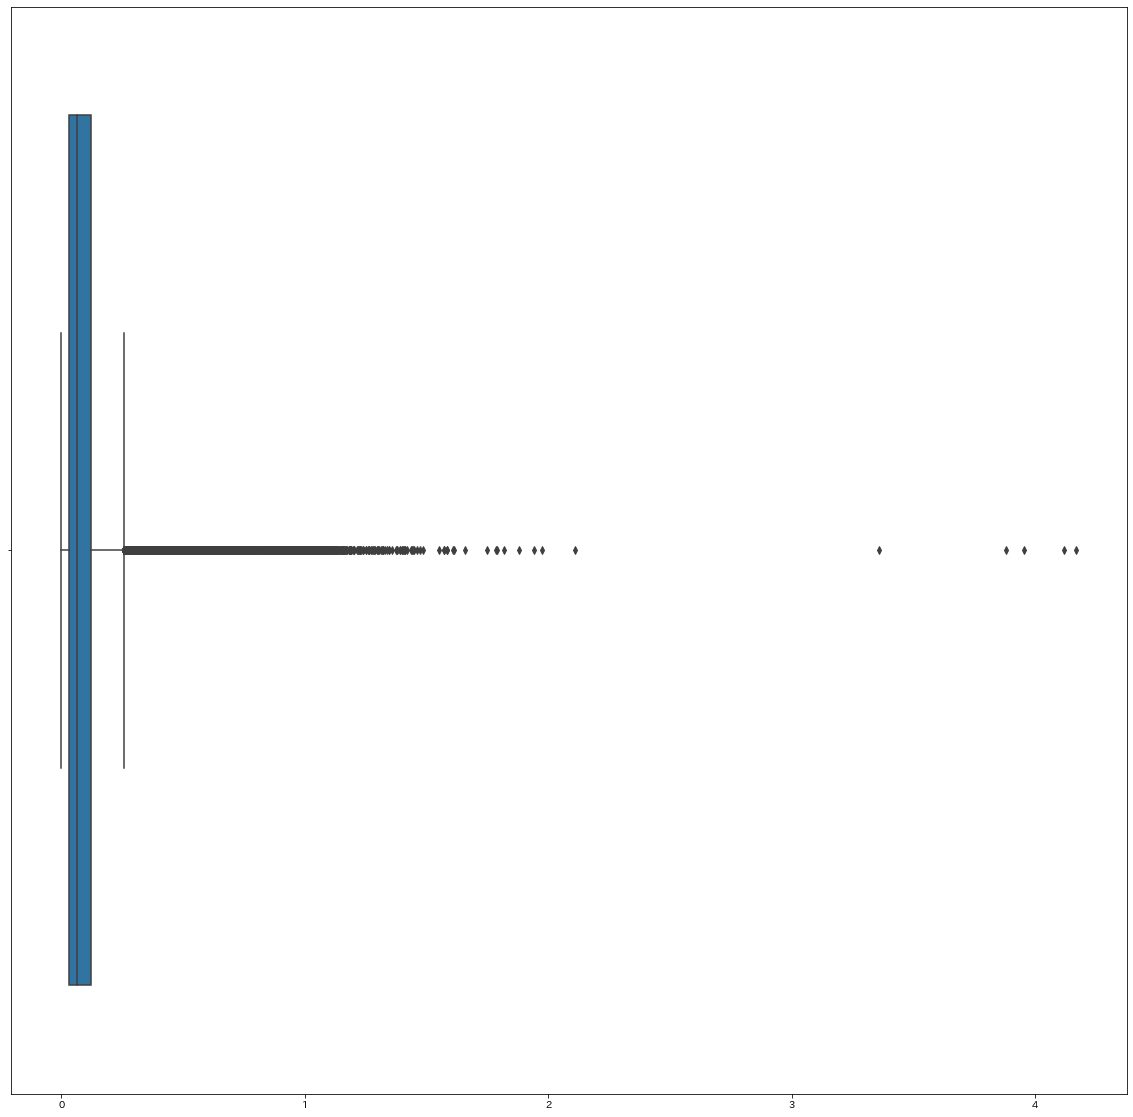

In [47]:
plt.figure(figsize=(20,20))
sns.boxplot(np.abs(test_yn-pred_test_cbr1))

In [65]:
#テストデータ読み込み
test=pd.read_csv('./data/test.csv')
#人口データ読み込み
#population_test=pd.read_csv('population_test.csv')
#提出用サンプルファイル読み込み
sample=pd.read_csv('./data/sample_submission.csv')

#欠損値の多いカラムを除去
#インスタンス化して訓練データを更新する
Adj_Data=Delete_Null_Data(test)
test=Adj_Data.delete_null_columns()

test.head()

,ID,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装
0,1000078,中古マンション等,1101,北海道,札幌市中央区,大通西,西１１丁目,1,３ＬＤＫ,75,平成28年,ＲＣ,住宅,住宅,商業地域,80.0,600.0,2021年第3四半期,未改装
1,1000121,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,0,１ＤＫ,30,昭和52年,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021年第3四半期,改装済
2,1000123,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,3,３ＬＤＫ,70,昭和59年,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021年第3四半期,改装済
3,1000127,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,2,２ＬＤＫ,50,昭和64年,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021年第4四半期,未改装
4,1000129,中古マンション等,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＤＫ,45,平成3年,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021年第4四半期,改装済


In [66]:
test=preprocess(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21005 entries, 0 to 21004
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         21005 non-null  int64  
 1   種類         21005 non-null  object 
 2   市区町村コード    21005 non-null  int64  
 3   都道府県名      21005 non-null  object 
 4   市区町村名      21005 non-null  object 
 5   地区名        21004 non-null  object 
 6   最寄駅：名称     21000 non-null  object 
 7   最寄駅：距離（分）  21000 non-null  object 
 8   間取り        19847 non-null  object 
 9   面積（㎡）      21005 non-null  int64  
 10  建築年        20404 non-null  object 
 11  建物の構造      19776 non-null  object 
 12  用途         15396 non-null  object 
 13  今後の利用目的    20081 non-null  object 
 14  都市計画       20701 non-null  object 
 15  建ぺい率（％）    20596 non-null  float64
 16  容積率（％）     20596 non-null  float64
 17  取引時点       21005 non-null  object 
 18  改装         18032 non-null  object 
dtypes: float64(2), int64(3), object(14)
memory usa

In [67]:
#面積をlogに変換
test['面積（㎡）']=np.log(test['面積（㎡）'])
test.head()

,ID,市区町村コード,都道府県名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装
0,1000078,1101,北海道,大通西,西１１丁目,1,３ＬＤＫ,4.317488,6.0,ＲＣ,住宅,住宅,商業地域,80.0,600.0,2021.50,未改装
1,1000121,1101,北海道,大通西,西１８丁目,0,１ＤＫ,3.401197,45.0,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021.50,改装済
2,1000123,1101,北海道,大通西,西１８丁目,3,３ＬＤＫ,4.248495,38.0,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021.50,改装済
3,1000127,1101,北海道,大通西,西１８丁目,2,２ＬＤＫ,3.912023,33.0,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021.99,未改装
4,1000129,1101,北海道,大通西,西１８丁目,2,１ＤＫ,3.806662,31.0,ＳＲＣ,住宅,住宅,商業地域,80.0,400.0,2021.99,改装済


In [68]:
test.to_csv('test_adjusted.csv', index=None)

In [58]:
"""
カテゴリ変数をint型の数値にエンコーディング
引数：カテゴリ変数をデータセット
戻り値：エンコーディングされたデータセット
"""

#カテゴリ変数をordinal encoding
from sklearn.preprocessing import OrdinalEncoder
#欠損値補完
from sklearn.impute import SimpleImputer

df_cat=test
oe=OrdinalEncoder()
#カテゴリ変数のカラム名
cat_features=['都道府県名', '地区名', '最寄駅：名称', '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装']
_df_X=df_cat[cat_features]

#変換してデータフレーム化(CataBoostはカテゴリ変数があるとエラーになる)
encoded_df_X=pd.DataFrame(oe.fit_transform(_df_X.values))
df_cat[cat_features]=encoded_df_X

#欠損値補完(CatBoostはNaNがあったらエラーになる)
imp=SimpleImputer()
df_cat=pd.DataFrame(imp.fit_transform(df_cat),columns=test.columns)
df_cat=df_cat.drop('ID',axis=1)

df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21005 entries, 0 to 21004
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   市区町村コード    21005 non-null  float64
 1   都道府県名      21005 non-null  float64
 2   地区名        21005 non-null  float64
 3   最寄駅：名称     21005 non-null  float64
 4   最寄駅：距離（分）  21005 non-null  float64
 5   間取り        21005 non-null  float64
 6   面積（㎡）      21005 non-null  float64
 7   建築年        21005 non-null  float64
 8   建物の構造      21005 non-null  float64
 9   用途         21005 non-null  float64
 10  今後の利用目的    21005 non-null  float64
 11  都市計画       21005 non-null  float64
 12  建ぺい率（％）    21005 non-null  float64
 13  容積率（％）     21005 non-null  float64
 14  取引時点       21005 non-null  float64
 15  改装         21005 non-null  float64
dtypes: float64(16)
memory usage: 2.6 MB


In [59]:
#予測
tmp_pred_cbr1=cbr1.predict(test)

#予測結果+面積
pred_cbr1=tmp_pred_cbr1+test['面積（㎡）']
pred_cbr1

0        7.745416
1        6.755714
2        7.375276
3        7.209730
4        7.197741
           ...   
21000    7.322235
21001    7.261360
21002    7.378124
21003    7.450588
21004    7.717126
Name: 面積（㎡）, Length: 21005, dtype: float64

In [60]:
#提出用ファイルに予測結果格納(LightGBM)
sample['取引価格（総額）_log']=pred_cbr1
sample.to_csv('submission_cbr2.csv', index=None)